# (Title to be decided)

*This is the file for the code of our group assignment. Under development.*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import time
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras_tuner.tuners import BayesianOptimization

# gpu acceleration, would cause an error when running without a cuda gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Set up a time calculation method for collecting time used during running the code:

In [2]:
# Variable for storing recorded timestamp
timer_record = 0

# Method for updating timer (setting the starting time)
def timer_start():
    global timer_record
    timer_record = time.time()

# Method for printing the time since last update
#
# the second num will be returned
def timer_read(print_result=True):
    second_passed = time.time() - timer_record
    if print_result:
        print(f"{second_passed:.3}s passed")
        return
    return second_passed


## 1. Read Data from External File

Read data in external files. For convenience, the original `.pcapng` file has been converted into `.json` and `.csv` with Wireshark.

In [3]:
# Read the JSON including all details of packets
#   errors="surrogateescape" to pass the encoding errors raised by contents in HTTP packets
with open("./data/traffic.json", "r", encoding="utf-8", errors="surrogateescape") as f:
    dataset_json=json.load(f)
    print(f"{len(dataset_json)} packets read")

# print one for checking
#dataset_json[0]

10625 packets read


## 2. Data Preprocessing

### 2.1 Extract dataset labels and encoding

In [4]:
# Extract labels(y) from JSON
dataset_y = np.array(list(map(
    lambda packet_json: (packet_json["_source"]["layers"]["pkt_comment"]["frame.comment"]).split(",")[1], 
    dataset_json
)))

print(f"Labels include {np.unique(dataset_y)}")
print(dataset_y.shape)

Labels include ['china' 'india' 'us']
(10625,)


### 2.2 Extract features

In [5]:
# Extract source IP, source IP host, destination IP and destination IP host from dataset
dataset_X_ip_src = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src"], 
    dataset_json
)))
dataset_X_ip_src_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.src_host"], 
    dataset_json
)))
dataset_X_ip_dst = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst"], 
    dataset_json
)))
dataset_X_ip_dst_host = np.array(list(map(
    lambda packet_json: packet_json["_source"]["layers"]["ip"]["ip.dst_host"], 
    dataset_json
)))

# print first ones for checking
print(dataset_X_ip_src[0])
print(dataset_X_ip_src_host[0])
print(dataset_X_ip_dst[0])
print(dataset_X_ip_dst_host[0])


10.11.1.3
10.11.1.3
8.8.8.8
dns.google


### 2.3 Check data sanity and deal with missing fields

In [6]:
# Data sanity check
pattern_not_ipv4 = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3}))")
pattern_not_ipv4_nor_domain = re.compile(r"(?!((\b25[0-5]|\b2[0-4][0-9]|\b[01]?[0-9][0-9]?)(\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)){3})|[-_0-9a-zA-Z]+\.[-_0-9a-zA-Z]+)")

print("Source/dest IP not an IPv4 address:")
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_src)))
print(list(filter(pattern_not_ipv4.match, dataset_X_ip_dst)))
print("Source/dest host not an IPv4 nor a domain:")
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_src_host)))
print(list(filter(pattern_not_ipv4_nor_domain.match, dataset_X_ip_dst_host)))

print()

# Fill the missing `dst.host`
#
# Find "no-data" rows
missing_dst_host_indexes = np.where(dataset_X_ip_dst_host=='no-data')[0]
print(f"Indexes of rows with missing 'dst.host': {missing_dst_host_indexes}")

# Fill the field with the IP address in `dst`, following the way of other rows
for i in missing_dst_host_indexes:
    dataset_X_ip_dst_host[i] = dataset_X_ip_dst[i]

print("Missing 'dst.host' filled")

Source/dest IP not an IPv4 address:
[]
[]
Source/dest host not an IPv4 nor a domain:
[]
['no-data', 'no-data']

Indexes of rows with missing 'dst.host': [960 964]
Missing 'dst.host' filled


### 2.4 Bi-gram for similarity between IPs and domains

In [7]:
# bi-gram for similar IP and hostnames
bigram_vec = CountVectorizer(ngram_range=(2, 2), token_pattern=r"(?u)[^.]+")
dataset_X_ip_src_bg = bigram_vec.fit_transform(dataset_X_ip_src).toarray()
dataset_X_ip_src_host_bg = bigram_vec.fit_transform(dataset_X_ip_src_host).toarray()
dataset_X_ip_dst_bg = bigram_vec.fit_transform(dataset_X_ip_dst).toarray()
dataset_X_ip_dst_host_bg = bigram_vec.fit_transform(dataset_X_ip_dst_host).toarray()

print(dataset_X_ip_src_bg.shape)
print(dataset_X_ip_src_host_bg.shape)
print(dataset_X_ip_dst_bg.shape)
print(dataset_X_ip_dst_host_bg.shape)

dataset_X = np.concatenate((
    dataset_X_ip_src_bg, 
    dataset_X_ip_src_host_bg,
    dataset_X_ip_dst_bg, 
    dataset_X_ip_dst_host_bg), axis=1)

print("")
print(dataset_X.shape)


(10625, 1402)
(10625, 867)
(10625, 1629)
(10625, 1059)

(10625, 4957)


### 2.5 Normalization

In [8]:
# Normalization
dataset_X = MinMaxScaler().fit_transform(dataset_X)
print(dataset_X.shape)

(10625, 4957)


### 2.6 Principal Component Analysis (PCA)

In [9]:
# # PCA - check the 95% with figure
# #
# # This part is not necessary for the main process and
# # can be commented out to save time
# pca = PCA()
# pca.fit(dataset_X)
# pca_cumsum = np.cumsum(pca.explained_variance_ratio_)

# plt.figure()
# plt.axis([0, dataset_X.shape[1], 0, 1]) 
# plt.plot(pca_cumsum)
# plt.axhline(y=0.95,color='red')
# plt.xlabel("dimensions")
# plt.ylabel("explained variance")
# plt.grid(True)
# plt.show()

In [10]:
timer_start()

# Apply PCA for compression
pca = PCA(n_components=0.95)
dataset_X = pca.fit_transform(dataset_X)

print(dataset_X.shape)
timer_read()

(10625, 650)
74.0s passed


### 2.7 Dataset split

In [11]:
# Split the dataset into training set and testing set
train_X, test_X, train_y, test_y = train_test_split(dataset_X, dataset_y)

print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(7968, 650)
(7968,)
(2657, 650)
(2657,)


## 3. Model Training

### 3.1 Logistic Regression

#### 3.1.1 Parameter Tuning

(This part is **not** necessary for generating the final result and can be commented out to save time)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model
lr = LogisticRegression(max_iter=10000)

# Search for the best C value using grid search CV
lr_param_grid = {
    'C': np.logspace(-2, 2, 5),
}
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5, scoring='accuracy', verbose=4)
lr_grid_search.fit(train_X, train_y)

# Print the best parameter and score
print("Best Parameter:    ", lr_grid_search.best_params_)
print("Score of the best: ", lr_grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ............................C=0.01;, score=0.806 total time=   0.2s
[CV 2/5] END ............................C=0.01;, score=0.795 total time=   0.2s
[CV 3/5] END ............................C=0.01;, score=0.815 total time=   0.2s
[CV 4/5] END ............................C=0.01;, score=0.806 total time=   0.3s
[CV 5/5] END ............................C=0.01;, score=0.823 total time=   0.2s
[CV 1/5] END .............................C=0.1;, score=0.881 total time=   0.6s
[CV 2/5] END .............................C=0.1;, score=0.877 total time=   0.7s
[CV 3/5] END .............................C=0.1;, score=0.873 total time=   0.6s
[CV 4/5] END .............................C=0.1;, score=0.879 total time=   0.6s
[CV 5/5] END .............................C=0.1;, score=0.880 total time=   0.6s
[CV 1/5] END .............................C=1.0;, score=0.891 total time=   1.5s
[CV 2/5] END .............................C=1.0;,

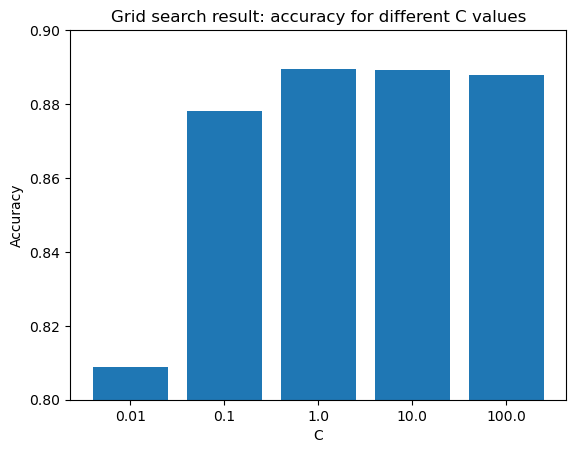

In [13]:
# Print the scores of all tested potential params
lr_grid_param_values = []
lr_grid_precision_values = []
for i, params in enumerate(lr_grid_search.cv_results_['params']):
    lr_grid_param_values.append(params['C'])
    lr_grid_precision_values.append(lr_grid_search.cv_results_['mean_test_score'][i])

# Plot the precision values for each parameter value
plt.bar(range(len(lr_grid_precision_values)), lr_grid_precision_values, tick_label=lr_grid_param_values)
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.9])
plt.title('Grid search result: accuracy for different C values')
plt.show()

Based on the bar chart, scores for 1, 10 and 100 are close to each other with minor differences. C=1 is chosen with its high performance and lowest time consumption between the three values.

#### 3.1.2 Model Training

In [14]:
timer_start()

lr = LogisticRegression(C=1.0, max_iter=1000)
lr.fit(train_X, train_y)

timer_read()

2.06s passed


### 3.2 Support Vector Machine (SVM)

TODO

In [15]:
#For the linear kernel (kernel_type='linear') svm
from sklearn.svm import SVC  # Support Vector Classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
SVM_linear = SVC(kernel='linear') 
SVM_linear.fit(train_X, train_y)
predict_results=SVM_linear.predict(test_X)
print(f"Accuracy on test set: {accuracy_score(predict_results, test_y):.4f}")

Accuracy on test set: 0.8965


In [16]:
#For the radial basis function kernel (kernel_type='rbf') svm
from sklearn.svm import SVC  # Support Vector Classifier
SVM_rbf = SVC(kernel='rbf')  
SVM_rbf.fit(train_X, train_y)
print(f"Accuracy on test set: {SVM_rbf.score(test_X, test_y):.4f}")

Accuracy on test set: 0.8991


In [17]:
#For the polynomial kernel (kernel_type='poly') svm
from sklearn.svm import SVC  # Support Vector Classifier
SVM_poly = SVC(kernel='poly') 
SVM_poly.fit(train_X, train_y)
print(f"Accuracy on test set: {SVM_poly.score(test_X, test_y):.4f}")

Accuracy on test set: 0.8995


In [18]:
#For the sigmoid function kernel (kernel_type='sigmoid') svm
from sklearn.svm import SVC  # Support Vector Classifier
SVM_sig = SVC(C=1, kernel='sigmoid', gamma=10, decision_function_shape='ovr')
SVM_sig.fit(train_X, train_y)
print(f"Accuracy on test set: {SVM_sig.score(test_X, test_y):.4f}")

Accuracy on test set: 0.3801


### 3.3 neural network

Data proccess

In [19]:
keras.backend.clear_session()

temp_train_y = pd.DataFrame(train_y, columns=['country'])
temp_train_y = pd.factorize(temp_train_y['country'], sort=True)[0]
train_X_nn, validate_X, train_y_nn, validate_y = train_test_split(train_X, temp_train_y, random_state=114514, test_size=0.3)

train_y_nn = keras.utils.to_categorical(train_y_nn, 3).astype('int32')
validate_y = keras.utils.to_categorical(validate_y, 3).astype('int32')

test_y_nn = pd.DataFrame(test_y, columns=['country'])
test_y_nn = pd.factorize(test_y_nn['country'], sort=True)[0]

print(train_X_nn.shape)
print(validate_X.shape)
print(train_y_nn.shape)
print(validate_y.shape)

(5577, 650)
(2391, 650)
(5577, 3)
(2391, 3)


Define model

In [20]:
def build_optimizer(hp):
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-4, step=1e-5)
    if optimizer == 'adam':
        return keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        return keras.optimizers.RMSprop(learning_rate=lr)
    else:
        return keras.optimizers.SGD(learning_rate=lr, momentum=hp.Float('momentum', min_value=0, max_value=0.9, step=0.02))

def build_model(hp):
    model = keras.models.Sequential(keras.layers.InputLayer(input_shape=[train_X.shape[1]]))
    model.add(keras.layers.Dense(hp.Int('neurons1', min_value=1, max_value=300, step=5),
                                 activation=hp.Choice('actv1', ['relu', 'tanh', 'sigmoid']),
                                 kernel_initializer='he_normal'))
    if hp.Boolean('second_layer', True):
        model.add(keras.layers.Dropout(hp.Float('dropout1', min_value=0, max_value=0.3, step=0.02)))
        model.add(keras.layers.Dense(hp.Int('neurons2', min_value=1, max_value=300, step=5),
                                     activation=hp.Choice('actv2', ['relu', 'tanh', 'sigmoid']),
                                     kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(3, activation="softmax"))

    model.compile(loss='categorical_crossentropy',
                  optimizer=build_optimizer(hp),
                  metrics=['accuracy'])
    return model

Bayesion optimization

In [21]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    project_name='neural_network_optimize'
)

tuner.search(x=train_X_nn, y=train_y_nn, epochs=35, validation_data=(validate_X, validate_y))

best_hps = tuner.get_best_hyperparameters()[0]
print(f'Best hyperparameters: {best_hps.values}')


INFO:tensorflow:Reloading Oracle from existing project ./neural_network_optimize/oracle.json
INFO:tensorflow:Reloading Tuner from ./neural_network_optimize/tuner0.json
INFO:tensorflow:Oracle triggered exit
Best hyperparameters: {'neurons1': 216, 'actv1': 'relu', 'second_layer': False, 'dropout1': 0.3, 'neurons2': 216, 'actv2': 'sigmoid', 'optimizer': 'adam', 'learning_rate': 7.000000000000001e-05, 'momentum': 0.0}


Model Trainning

In [22]:
optimized_model = build_model(best_hps)
history = optimized_model.fit(train_X_nn, train_y_nn, epochs=35,
                     validation_data=(validate_X, validate_y))
optimized_model.summary()

Epoch 1/35


2023-03-23 21:20:52.279522: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


175/175 [==============================] - 0s 1ms/step - loss: 1.0524 - accuracy: 0.5360 - val_loss: 0.9912 - val_accuracy: 0.7089
Epoch 2/35
175/175 [==============================] - 0s 986us/step - loss: 0.9350 - accuracy: 0.7726 - val_loss: 0.8860 - val_accuracy: 0.7951
Epoch 3/35
175/175 [==============================] - 0s 1ms/step - loss: 0.8320 - accuracy: 0.8105 - val_loss: 0.7908 - val_accuracy: 0.8135
Epoch 4/35
175/175 [==============================] - 0s 951us/step - loss: 0.7377 - accuracy: 0.8282 - val_loss: 0.7033 - val_accuracy: 0.8239
Epoch 5/35
175/175 [==============================] - 0s 1ms/step - loss: 0.6528 - accuracy: 0.8427 - val_loss: 0.6259 - val_accuracy: 0.8356
Epoch 6/35
175/175 [==============================] - 0s 2ms/step - loss: 0.5799 - accuracy: 0.8526 - val_loss: 0.5611 - val_accuracy: 0.8415
Epoch 7/35
175/175 [==============================] - 0s 1ms/step - loss: 0.5194 - accuracy: 0.8591 - val_loss: 0.5078 - val_accuracy: 0.8469
Epoch 8/35
17

Output

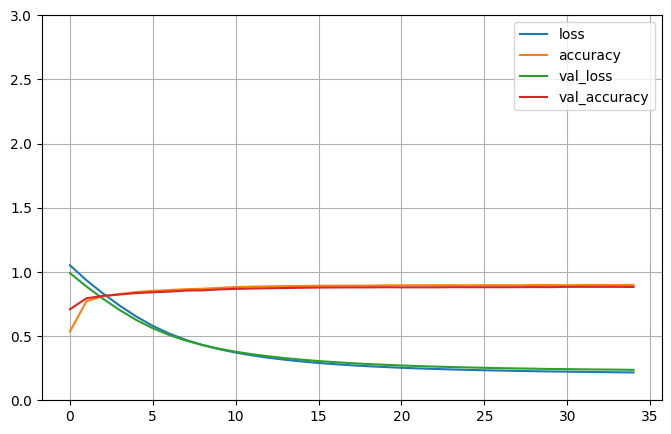

84/84 [==============================] - 0s 515us/step
Accuracy on test set: 89.65%


In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

y_pred = optimized_model.predict(test_X)
prediction = np.argmax(y_pred, axis=1)
count=0
for i,j in zip(prediction, test_y_nn):
  if i==j:
    count+=1
print(f'Accuracy on test set: {count*100/test_y_nn.shape[0]:.2f}%')

## 4. Model Testing and Comparison

### 4.1 Test Results

In [16]:
# NOTE
# TODO: REMOVE BEFORE SUBMIT

# For team members - Structure of a result dict (example):
#
# Add additional key/values if feel necessary

example_lr_results = {
    "f1_score": 0.12,
    "recall": 0.34,
    "precision": 0.56,
    "accuracy": 0.78,

    "by_labels": {  # VALUES FOR DIFFERENT COUNTRY CATEGORIES
        "labels": ['china', 'india', 'us'],  # country name labels, should be the same for every one
        "f1_score": [ 0.12, 0.34, 0.56],
        "recall": [ 0.12, 0.34, 0.56],
        "precision": [ 0.12, 0.34, 0.56],
    }
}



#### 4.1.1 Logistic Regression

In [17]:
# Make prediction on the test set
lr_y_pred = lr.predict(test_X)

In [18]:
# Generate and save evaluation results

# Variable for storing the evaluation of logistic regression
lr_results={}

lr_results["f1_score"] = metrics.f1_score(test_y, lr_y_pred, average='macro')
lr_results["recall"] = metrics.recall_score(test_y, lr_y_pred, average='macro')
lr_results["precision"] = metrics.precision_score(test_y, lr_y_pred, average='macro')
lr_results["accuracy"] = metrics.accuracy_score(test_y, lr_y_pred)

lr_results["by_label"] = {}
lr_results["by_label"]["labels"] = np.sort(np.unique(dataset_y))  # for metric functions, all labels are used in sorted order
lr_results["by_label"]["f1_score"] = metrics.f1_score(test_y, lr_y_pred, average=None)
lr_results["by_label"]["recall"] = metrics.recall_score(test_y, lr_y_pred, average=None)
lr_results["by_label"]["precision"] = metrics.precision_score(test_y, lr_y_pred, average=None)

# Print formatted classification report
print(metrics.classification_report(test_y, lr_y_pred))

# Check the result dict
print()
print(lr_results)

              precision    recall  f1-score   support

       china       0.98      0.90      0.94       746
       india       0.83      0.89      0.86      1022
          us       0.85      0.83      0.84       889

    accuracy                           0.88      2657
   macro avg       0.89      0.88      0.88      2657
weighted avg       0.88      0.88      0.88      2657


{'f1_score': 0.8804142851211477, 'recall': 0.8760830370881373, 'precision': 0.8865444219246043, 'accuracy': 0.8754234098607452, 'by_label': {'labels': array(['china', 'india', 'us'], dtype='<U5'), 'f1_score': array([0.94002789, 0.86078339, 0.84043157]), 'recall': array([0.90348525, 0.89236791, 0.83239595]), 'precision': array([0.97965116, 0.83135825, 0.84862385])}}


#### 4.1.2 SVM

#### 4.1.3 The Neural Network

### 4.2 Result Comparison

TODO